# Multilayer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Multilayer Perceptron is a type of artificial neural network that consists of multiple layers of interconnected nodes, called neurons. It is a feedforward neural network, meaning that the information flows in one direction, from the input layer to the output layer.

MLP is widely used in various machine learning tasks, such as classification, regression, and pattern recognition. It is known for its ability to learn complex patterns and make accurate predictions.

In [2]:
# Plot the decision boundary of a classifier
# Not really important for the course
def plotgrid(f, dr=0):
    result = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            x = np.array([i/100.0, j/100.0])
            z = f(x)
            if dr==0:
                z /= sum(z)
                result[i,j] = z[1]
            else:
                result[i,j] = np.argmax(z)
    return result.T[::-1]

In [3]:
def random_data():
    data = np.random.random_sample((100,2))
    labels = (data[:,0]-data[:,1]<0)

    d0 = data[labels==False]
    d1 = data[labels]

    targets = np.array([labels, 1-labels]).T
    return data, targets, labels, d0, d1

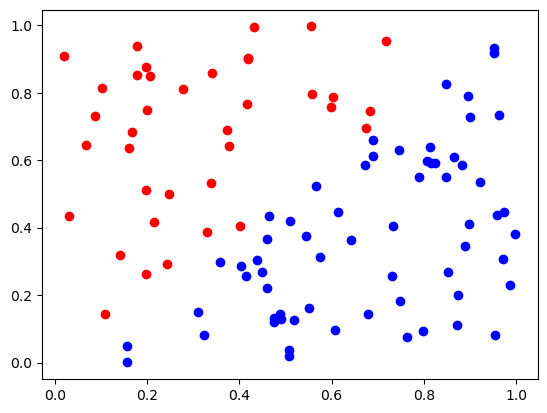

In [4]:
data, targets, labels, d0, d1 = random_data()
plt.plot(d0[:,0], d0[:, 1],"bo")
plt.plot(d1[:,0], d1[:, 1],"ro")

In [5]:
class Loss:
    def __init__(self):
        pass

    def forward(self, input, target):
        self.input = input
        self.target = target
        return 0.5*np.sum((target-input)**2)

    def backward(self):
        return -(self.target - self.inupt)

class Fully:
    def __init__(self, num, input_length):
        self.neurons = num
        self.weights = np.random.random((self.neurons, input_length))

    def forward(self, input):
        self.input = input
        self.result = np.dot(self.weights, input)
        return self.result

    def backward(self, back):
        x = np.outer(back,self.input)
        old_weights = self.weights
        self.weights -= x
        return np.dot(old_weights.T,back)

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, input):
        self.result = 1/(1+np.exp(-input))
        return self.result

    def backward(self, back):
        z = self.result*(1-self.result)
        x = back*z
        return x

class Network:
    f = Fully(5, 2)
    fs = Sigmoid()
    f2 = Fully(2,5)
    s = Sigmoid()

    def forward(self, inp):
        x = self.f.forward(inp)
        xs = self.fs.forward(x)
        y = self.f2.forward(xs)
        ys = self.s.forward(y)
        return ys

    def backward(self, error):
        ys = self.s.backward(error)
        y = self.f2.backward(ys)
        xs = self.fs.backward(y)
        self.f.backward(xs)

network = Network()

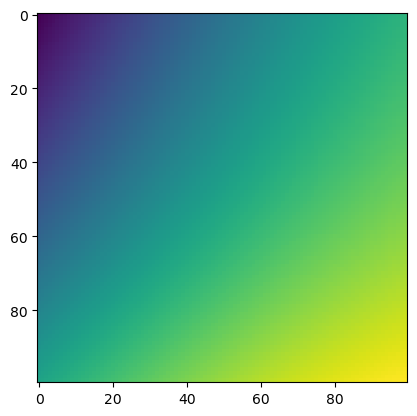

In [6]:
# Before training, the decision boundary is fuzzy and random
plt.imshow(plotgrid(network.forward, dr=0))

Correct predicted:  1.0


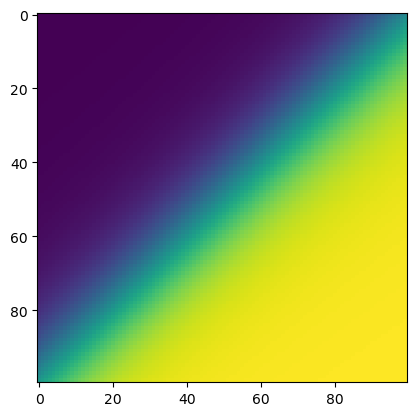

In [7]:
for e in range(1000):
    i = np.random.randint(0,len(data))
    out = network.forward(data[i])
    network.backward(-(targets[i]-out))
total = len(data)
good = 0
for i in range(len(data)):
    out = np.argmax(network.forward(data[i]))
    if out==np.argmax(targets[i]):
        good += 1

print("Correct predicted: ", 1.0*good/total)
plt.imshow(plotgrid(network.forward, dr=0))